In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray'
from itertools import cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import os
from skimage.io import imread, imsave
from IPython.display import clear_output
from skimage.util import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
from skimage.color import label2rgb
import h5py

In [6]:
with h5py.File('out_cartoons.h5', 'r') as h:
    val_dict = {}
    for k in h.keys():
        print(k, h[k].shape)
        val_dict[k] = list(h[k])
    cartoon_df = pd.DataFrame(val_dict)
    del val_dict
cartoon_df.sample(3)

chin_length (10000,)
eye_angle (10000,)
eye_color (10000,)
eye_eyebrow_distance (10000,)
eye_lashes (10000,)
eye_lid (10000,)
eye_slant (10000,)
eyebrow_shape (10000,)
eyebrow_thickness (10000,)
eyebrow_weight (10000,)
eyebrow_width (10000,)
face_color (10000,)
face_shape (10000,)
facial_hair (10000,)
glasses (10000,)
glasses_color (10000,)
hair (10000,)
hair_color (10000,)
image (10000, 128, 128, 3)


chin_length  eye_angle  eye_color  eye_eyebrow_distance  eye_lashes  \
6389            1          0          4                     0           1   
4261            0          0          4                     0           1   
205             2          2          4                     1           1   

      eye_lid  eye_slant  eyebrow_shape  eyebrow_thickness  eyebrow_weight  \
6389        1          2             11                  2               1   
4261        0          0              6                  1               0   
205         1          1              7                  3               0   

      eyebrow_width  face_color  face_shape  facial_hair  glasses  \
6389              2           0           4           14       11   
4261              0           8           5           10        7   
205               0           9           0           14       11   

      glasses_color  hair  hair_color  \
6389              0    81           8   
4261              3    88           3   
205               2    92           7   

                                                  image  
6389  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
4261  [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
205   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...

In [7]:
val_count = {}
for c_col in cartoon_df.columns:
    if c_col not in ['image']:
        val_count[c_col] = cartoon_df[c_col].value_counts().index.max()+1
print(sum(val_count.values()), 'states')
val_count

217 states


{'chin_length': 3,
 'eye_angle': 3,
 'eye_color': 5,
 'eye_eyebrow_distance': 3,
 'eye_lashes': 2,
 'eye_lid': 2,
 'eye_slant': 3,
 'eyebrow_shape': 14,
 'eyebrow_thickness': 4,
 'eyebrow_weight': 2,
 'eyebrow_width': 3,
 'face_color': 11,
 'face_shape': 7,
 'facial_hair': 15,
 'glasses': 12,
 'glasses_color': 7,
 'hair': 111,
 'hair_color': 10}

In [8]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(cartoon_df, 
                                     random_state=0, 
                                     test_size=0.25)

In [9]:
from keras import layers, models
from keras.losses import mse, binary_crossentropy
from keras.utils.vis_utils import plot_model
def plot_model(*args, **kwargs):
    try:
        return pm_raw(*args, **kwargs)
    except Exception as e:
        print(e)
from keras import backend as K

In [10]:
original_shape = train_df['image'].shape[1:]
original_dim = np.prod(original_shape)

ARGS_MSE = False
EPOCHS = 100
BATCH_SIZE = 64
TARGET_DIM_SIZE = 128
TARGET_LATENT_SIZE = 2
recon_loss_func = mse if ARGS_MSE else binary_crossentropy

In [11]:
# Q(z|X), sample epsilon = N(0,I)
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def z_log_loss(_, x):
    return K.exp(x)-x


def z_mean_loss(_, x):
    return K.square(x)

# VAE

In [12]:
def build_dcgan_vae(input_shape,
                    intermediate_dim=TARGET_DIM_SIZE,
                    latent_dim=TARGET_LATENT_SIZE,
                    cnn_blocks=5,
                    cnn_depth=8):
    # VAE model = encoder + decoder
    raw_inputs = layers.Input(shape=input_shape, name='encoder_input')
    cur_x = raw_inputs
    for i in range(cnn_blocks):
        cur_x = layers.Conv2D(cnn_depth*2**i,
                              (3, 3),
                              activation='linear',
                              padding='same',
                              strides=(2, 2),
                              use_bias=False)(cur_x)
        cur_x = layers.BatchNormalization()(cur_x)
        cur_x = layers.LeakyReLU(0.2)(cur_x)
    inputs = layers.Flatten()(cur_x)
    x = layers.Dense(intermediate_dim, activation='relu')(inputs)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    z = layers.Lambda(sampling, output_shape=(
        latent_dim,), name='z')([z_mean, z_log_var])

    encoder = models.Model(raw_inputs, [z_mean, z_log_var, z], name='encoder')
    plot_model(encoder, to_file='vae_dcgan_encoder.png', show_shapes=True)

    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
    int_shape = (input_shape[0]//2**cnn_blocks,
                 input_shape[1]//2**cnn_blocks,
                 cnn_depth*2**cnn_blocks)
    ds_features = layers.Dense(np.prod(int_shape).astype(int),
                               activation='relu', name='decoding_blcok')(x)
    ds_features = layers.Reshape(int_shape)(ds_features)
    cur_x = ds_features
    for i in range(cnn_blocks):
        cur_x = layers.UpSampling2D((2, 2))(cur_x)
        cur_x = layers.Conv2D(cnn_depth*2**(cnn_blocks-i),
                              (3, 3),
                              padding='same',
                              activation='linear',
                              use_bias=False
                              )(cur_x)
        cur_x = layers.BatchNormalization()(cur_x)
        cur_x = layers.LeakyReLU(0.2)(cur_x)

    formed_output = layers.Conv2D(
        input_shape[2], (1, 1), activation='sigmoid')(cur_x)

    decoder = models.Model(latent_inputs, formed_output, name='decoder')
    plot_model(decoder, to_file='vae_dcgan_decoder.png', show_shapes=True)


    def rename_tensor(last_tensor, name): return layers.Lambda(
        lambda y: y, name=name)(last_tensor)
    enc_z_mean, enc_z_log_var, enc_z = [rename_tensor(c_lay, c_name) for c_name, c_lay in zip(
        ['enc_z_mean', 'enc_z_log_var', 'enc_z'], encoder(raw_inputs))]

    outputs = decoder(enc_z)
    vae = models.Model(inputs=[raw_inputs],
                       outputs=[outputs, enc_z_mean,
                                enc_z_log_var, enc_z],
                       name='vae_dcgan')
    vae.summary()

    vae.compile(optimizer='adam',
                loss={'enc_z_mean': z_mean_loss,
                      'enc_z_log_var': z_log_loss, 'decoder': recon_loss_func},
                loss_weights={'decoder': np.prod(
                    input_shape), 'enc_z_log_var': 0.5, 'enc_z_mean': 0.5},
                metrics={'decoder': 'mae'}
                )
    plot_model(vae, to_file='vae_dcgan.png', show_shapes=True)

    return encoder, decoder, vae

In [13]:
safe_shape = lambda x: np.stack(x.values, 0)[:, :, :, :]/255.0
def make_bundle(in_df):
    out_dict = {
            'decoder': safe_shape(in_df['image']),
            'enc_z_mean': np.zeros((in_df.shape[0], 2)),
            'enc_z_log_var': np.zeros((in_df.shape[0], 2)),     
        }
    return (
        {'encoder_input': safe_shape(in_df['image'])},
        out_dict
    )
train_bundle = make_bundle(train_df)
valid_bundle = make_bundle(test_df)
original_shape = train_bundle[0]['encoder_input'].shape[1:]
print(original_shape)

(128, 128, 3)


In [14]:
encoder, decoder, vae = build_dcgan_vae(original_shape, cnn_depth=16, cnn_blocks=5)
encoder.summary()

2022-01-04 20:51:11.122124: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 20:51:11.179901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 20:51:11.180044: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 20:51:11.180558: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

name 'pm_raw' is not defined
name 'pm_raw' is not defined
Model: "vae_dcgan"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder (Functional)           [(None, 2),          919028      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 enc_z (Lambda)                 

In [22]:
base_dcgan_vae_history = vae.fit(
    x=train_bundle[0],
    y=train_bundle[1],
    validation_data=valid_bundle,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE)
clear_output()

2022-01-04 20:55:20.105504: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1474560000 exceeds 10% of free system memory.
2022-01-04 20:55:31.065318: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.37GiB (rounded to 1474560000)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-01-04 20:55:31.065342: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-01-04 20:55:31.065353: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 71, Chunks in use: 70. 17.8KiB allocated for chunks. 17.5KiB in use in bin. 3.5KiB client-requested in use in bin.
2022-01-04 20:55:31.065358: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

n.
2022-01-04 20:55:31.065416: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (2097152): 	Total Chunks: 2, Chunks in use: 1. 4.00MiB allocated for chunks. 2.00MiB in use in bin. 2.00MiB client-requested in use in bin.
2022-01-04 20:55:31.065421: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (4194304): 	Total Chunks: 3, Chunks in use: 2. 13.00MiB allocated for chunks. 8.50MiB in use in bin. 8.50MiB client-requested in use in bin.
2022-01-04 20:55:31.065425: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (8388608): 	Total Chunks: 3, Chunks in use: 1. 26.00MiB allocated for chunks. 9.00MiB in use in bin. 9.00MiB client-requested in use in bin.
2022-01-04 20:55:31.065430: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (16777216): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-01-04 20:55:31.065434: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (33554432

In [16]:
def show_training_results(**named_model_histories):
    model_out = list(named_model_histories.items())
    test_keys = [k for k in model_out[0]
                 [1].history.keys() if not k.startswith('val_')]
    fig, m_axs = plt.subplots(
        2, len(test_keys), figsize=(4*len(test_keys), 10))
    for c_key, (c_ax, val_ax) in zip(test_keys, m_axs.T):
        c_ax.set_title('Training: {}'.format(c_key.replace('_', ' ')))
        val_ax.set_title('Validation: {}'.format(c_key.replace('_', ' ')))
        for model_name, model_history in model_out:
            c_ax.plot(model_history.history[c_key], label=model_name)
            val_key = 'val_{}'.format(c_key)
            if val_key in model_history.history:
                val_ax.plot(
                    model_history.history[val_key], '-', label=model_name)

        c_ax.legend()
        val_ax.legend()


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_vars = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    col_count = np.sqrt(len(y_vars)).astype(int)
    fig, m_ax = plt.subplots(col_count, col_count, figsize=(30, 30))
    for c_ax, (y_name, y_test) in zip(m_ax.flatten(), y_vars.items()):
        for k in np.unique(y_test):
            c_ax.plot(z_mean[y_test == k, 0], z_mean[y_test == k, 1],
                     '.', label='{:2.0f}'.format(k))
            c_ax.set_title(y_name)
        c_ax.legend()
        c_ax.set_xlabel("z[0]")
        c_ax.set_ylabel("z[1]")
    
    fig.savefig(filename)

    filename = os.path.join(model_name, "digits_over_latent.png")
    n = 10
    digit_size_x = original_shape[0]
    digit_size_y = original_shape[1]
    digit_shape_c = original_shape[2]
    figure = np.zeros((digit_size_x * n, digit_size_y * n, digit_shape_c))

    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(
                digit_size_x, digit_size_y, digit_shape_c)
            figure[i * digit_size_x: (i + 1) * digit_size_x,
                   j * digit_size_y: (j + 1) * digit_size_y] = digit

    plt.figure(figsize=(10, 10), dpi=300)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure[:, :].squeeze(), cmap='Greys_r')
    plt.savefig(filename)
    imsave(filename+'_raw.png', figure)
    plt.show()

    features_test = encoder.predict(x_test)[-1]
    plt.hist2d(features_test[:, 0],
               features_test[:, 1],
               bins=30)

    fig, ax1 = plt.subplots(1, 1, figsize=(12, 10))
    ax1.plot(features_test[:, 0])
    ax1.plot(features_test[:, 1])

In [17]:
show_training_results(dcgan = base_dcgan_vae_history)

NameError: name 'base_dcgan_vae_history' is not defined

2022-01-04 20:51:49.254682: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2022-01-04 20:51:49.724149: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-04 20:51:49.724548: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-04 20:51:49.724558: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-01-04 20:51:49.724763: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-04 20:51:49.724783: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
/tmp/ipykernel_2664/4270371152.py:69: UserWarning: vae_dcgan/di

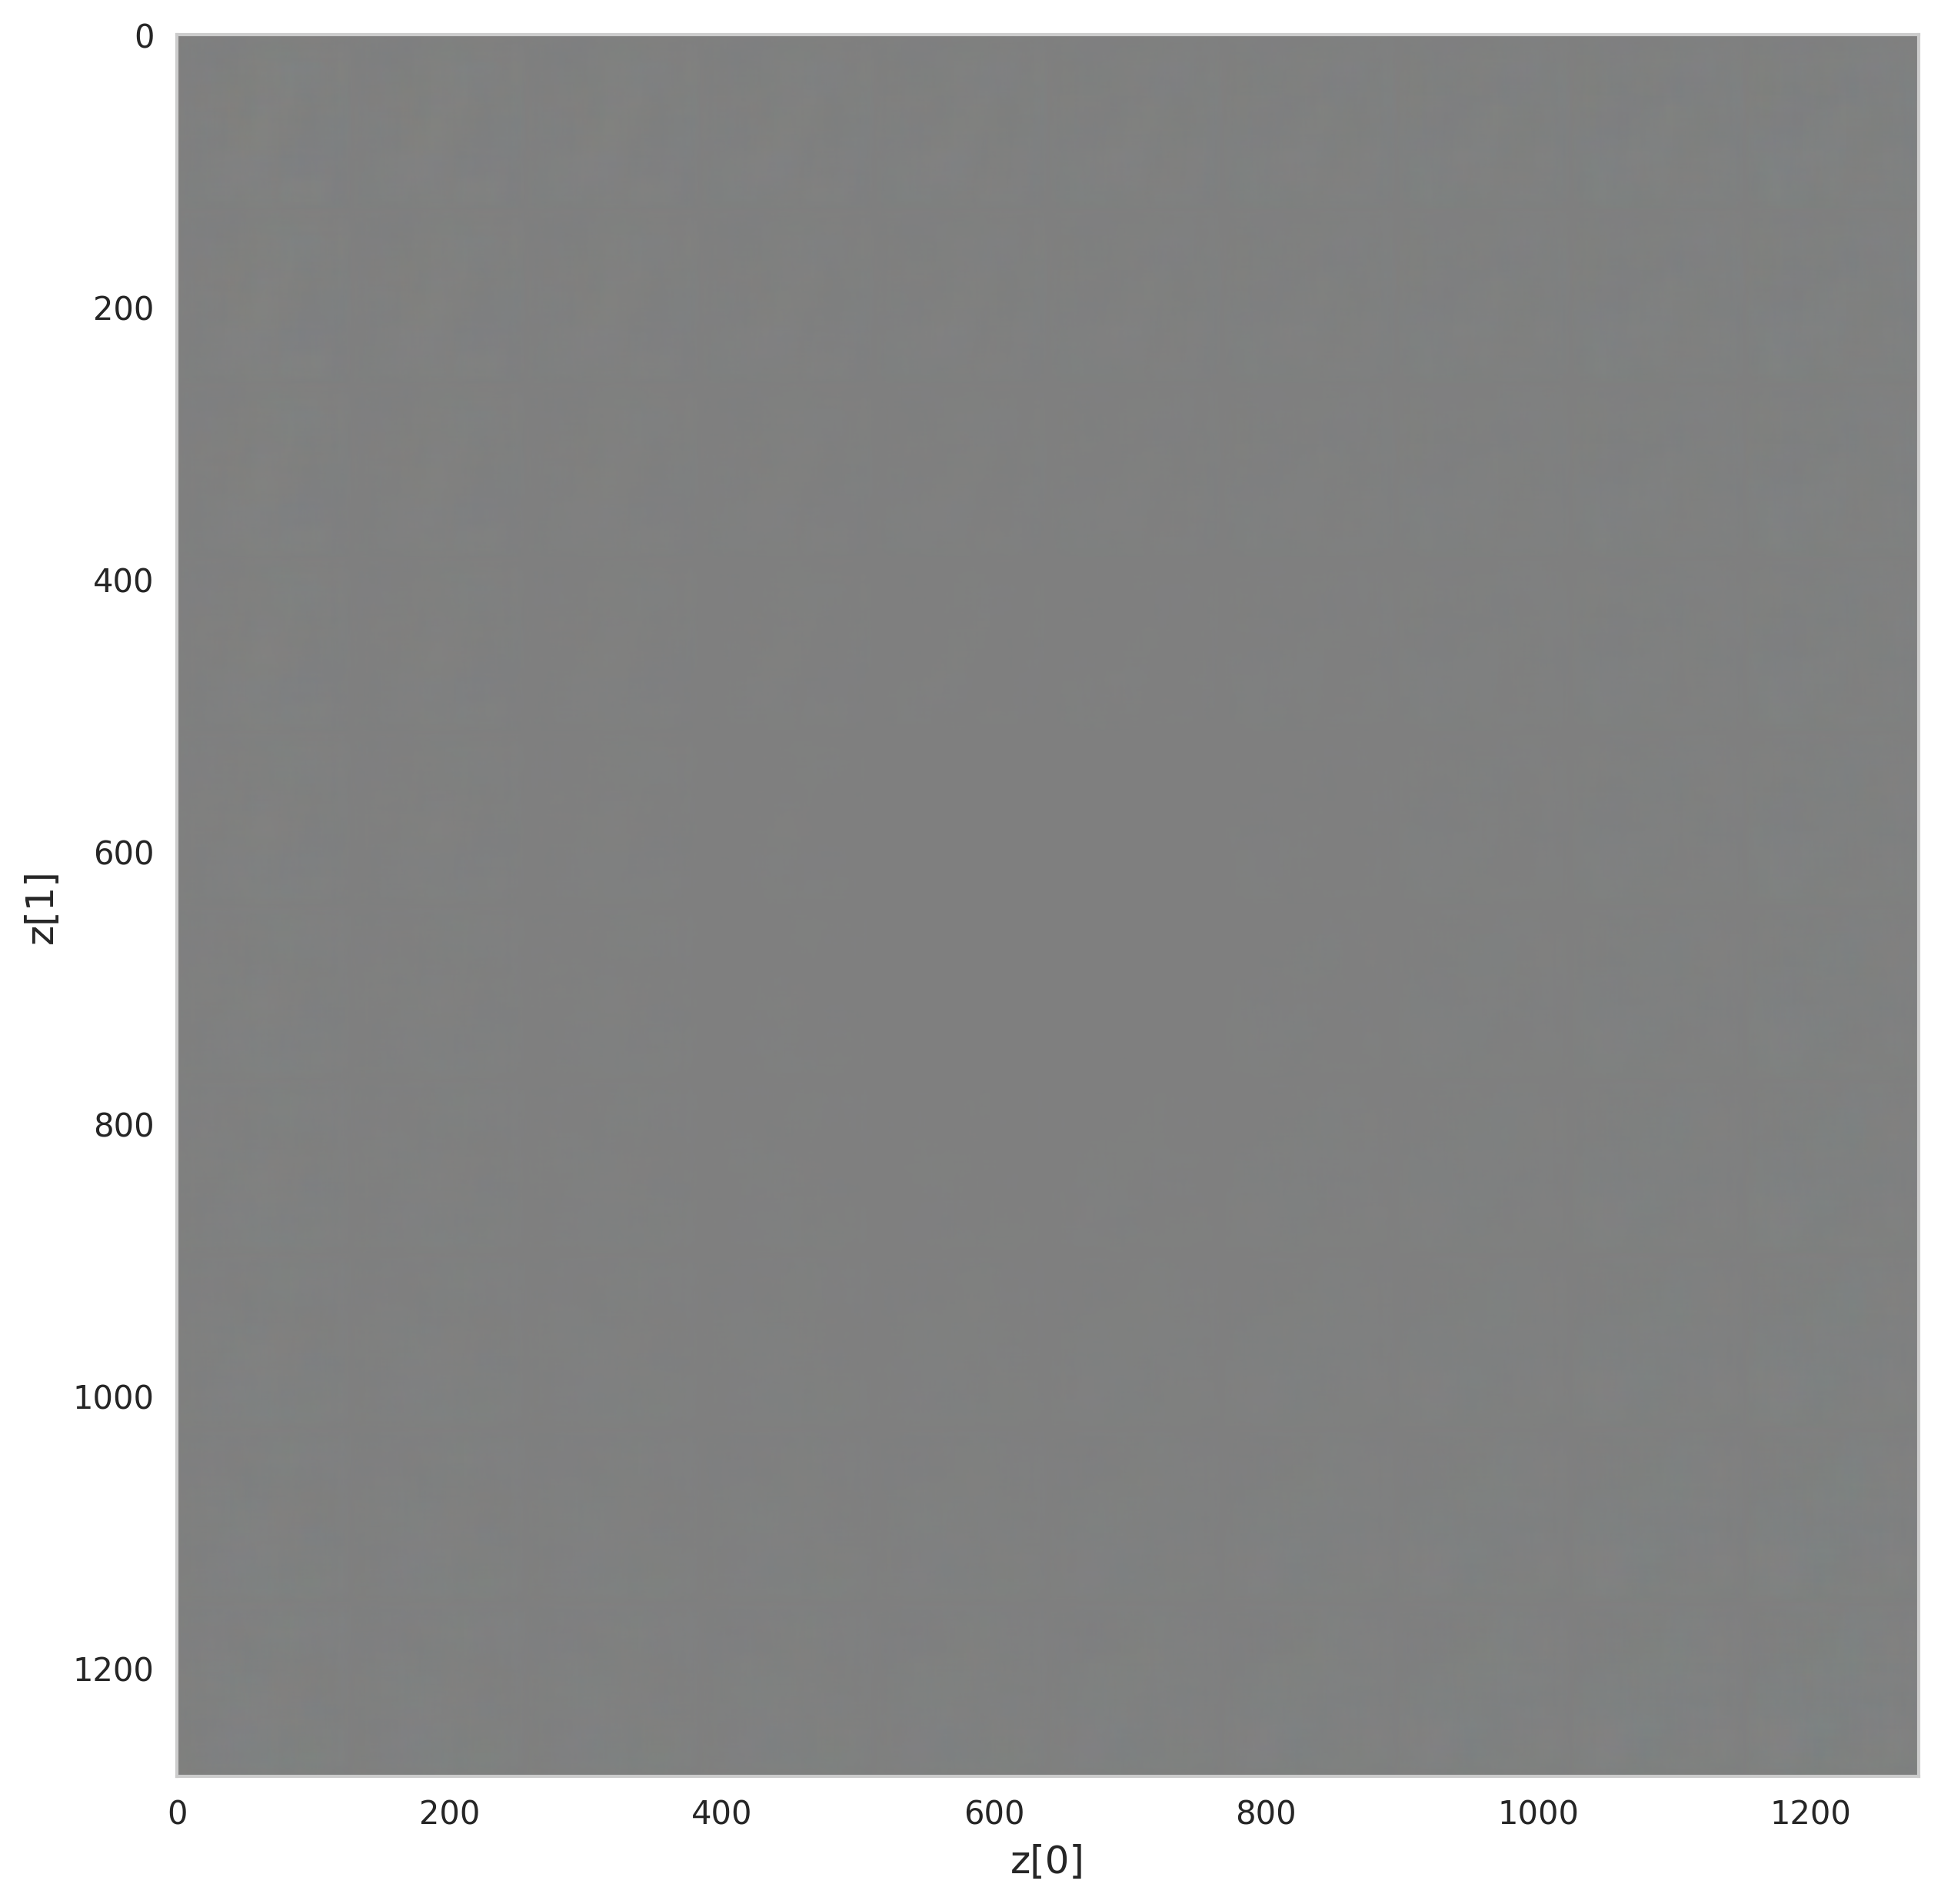

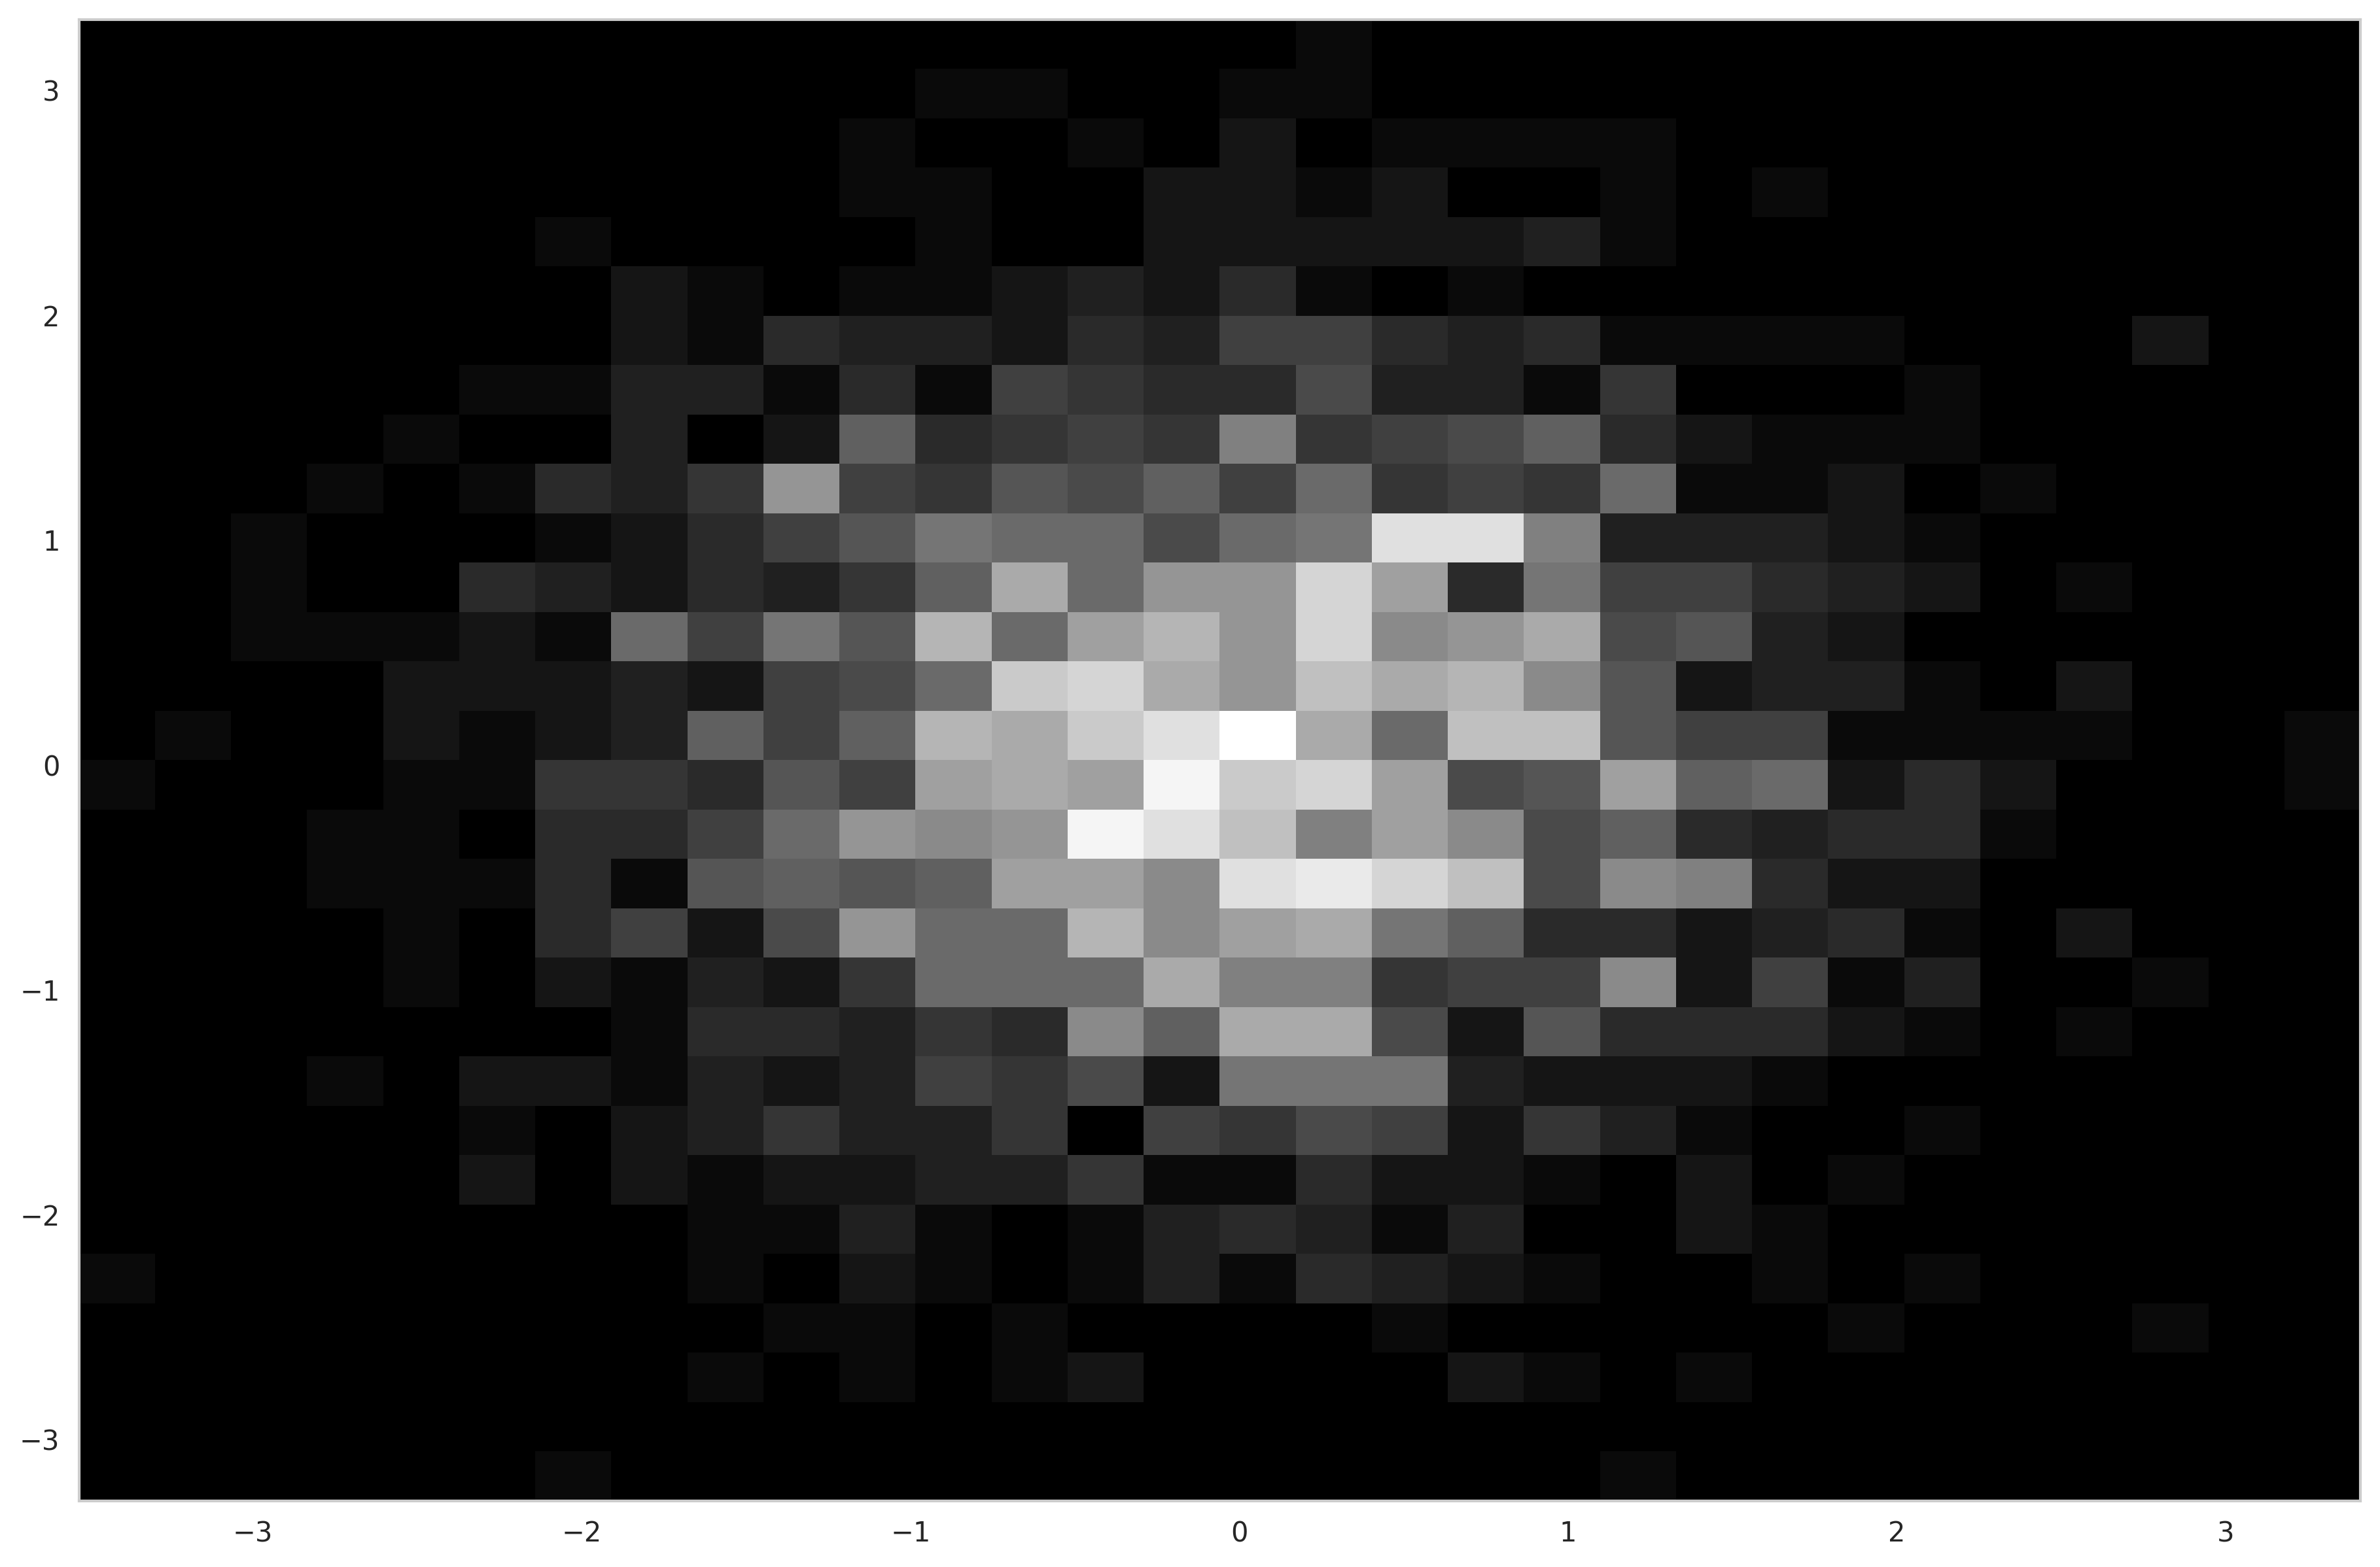

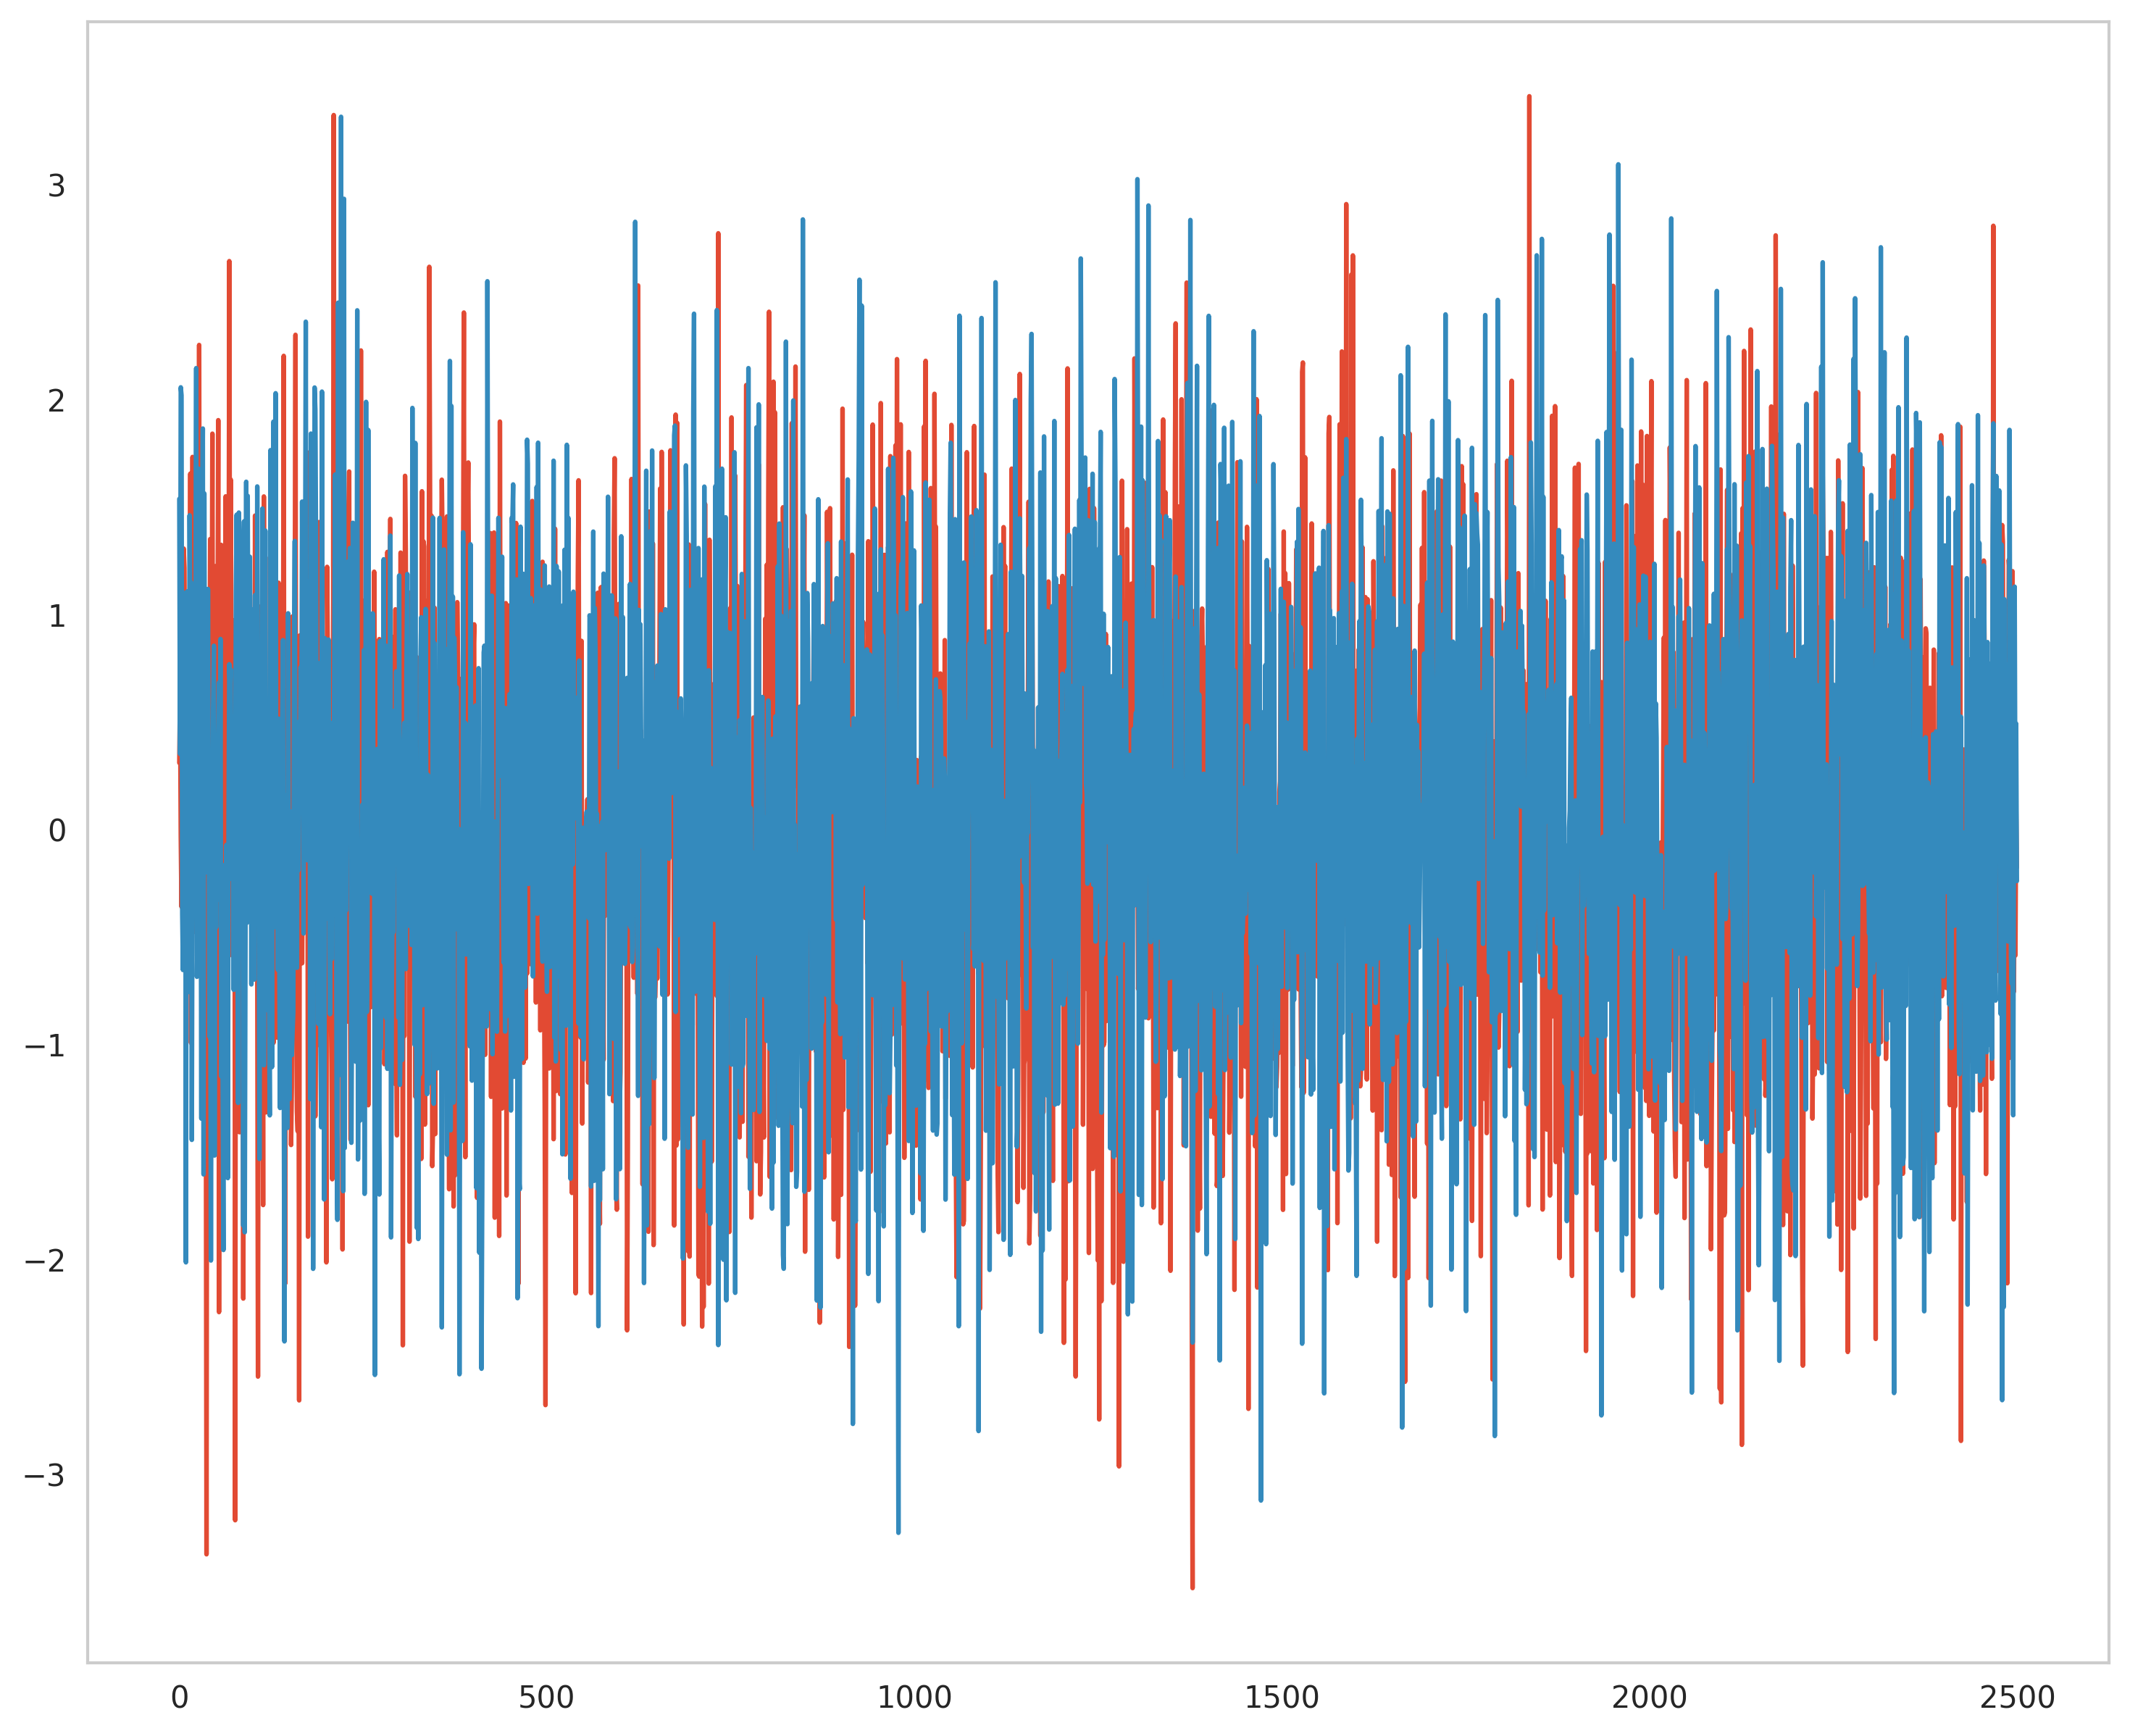

In [18]:
plot_results((encoder, decoder),
             (safe_shape(test_df['image']), 
              {c_col: test_df[c_col] for c_col in val_count.keys()}),
             batch_size=BATCH_SIZE,
             model_name="vae_dcgan")